In [1]:
import keras
from keras.layers import Conv1D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import pandas as pd
import numpy as np
!pip install spectral
import spectral
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.3 MB/s eta 0:00:00


In [2]:
def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y


In [3]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros(
        (X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


In [5]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    print(X.shape[0], X.shape[1], X.shape[2], zeroPaddedX.shape)
    patchesData = np.zeros(
        (X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin,2):
        for c in range(margin, zeroPaddedX.shape[1] - margin,2):
            patch = zeroPaddedX[r - margin:r +
                                margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [6]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [7]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [8]:
test_ratio = 0.7
windowSize = 25

# INDIAN PINES **1DCNN**

In [9]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [10]:
K=30

In [11]:
X, pca = applyPCA(X, numComponents=K)

X.shape


(145, 145, 30)

In [12]:
print(X.shape)
print(y.shape)

(145, 145, 30)
(145, 145)


In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

145 145 30 (169, 169, 30)


((2560, 25, 25, 30), (2560,))

In [14]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [15]:
y

array([2., 2., 2., ..., 9., 9., 9.])

In [16]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(768, 25, 25, 30)
(1792, 25, 25, 30)
(768,)
(1792,)


In [17]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(768, 16)

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(768, 25, 25, 30, 1)

In [19]:

S = windowSize
L = K
output_units =16

In [20]:
## input layer
from keras.layers import Conv1D
input_layer = Input((S, S, L, 1))

conv_layer1 = Conv1D(filters=8, kernel_size=(3), activation='relu')(input_layer)
conv_layer2 = Conv1D(filters=16, kernel_size=(3), activation='relu')(conv_layer1)
conv_layer3 = Conv1D(filters=32, kernel_size=(3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape

flatten_layer = Flatten()(conv_layer3)

print(conv_layer3.shape, flatten_layer.shape)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 25, 25, 24, 32)
(None, 25, 25, 24, 32) (None, 480000)


In [21]:
model = Model(inputs=input_layer, outputs=output_layer)

In [22]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv1d (Conv1D)             (None, 25, 25, 28, 8)     32        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 25, 26, 16)    400       
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 25, 24, 32)    1568      
                                                                 
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 256)               122880256 
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [23]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [24]:
filepath = "./best_model_1dcnn.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='acc', verbose=1, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256,
                    epochs=20, callbacks=callbacks_list)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 19.0138 - accuracy: 0.1198
Epoch 1: saving model to ./best_model_1dcnn.hdf5
3/3 [==============================] - 12s 1s/step - loss: 19.0138 - accuracy: 0.1198
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 11.6064 - accuracy: 0.1732
Epoch 2: saving model to ./best_model_1dcnn.hdf5
3/3 [==============================] - 3s 1s/step - loss: 11.6064 - accuracy: 0.1732
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 4.5542 - accuracy: 0.1953
Epoch 3: saving model to ./best_model_1dcnn.hdf5
3/3 [==============================] - 5s 2s/step - loss: 4.5542 - accuracy: 0.1953
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 2.4912 - accuracy: 0.3346
Epoch 4: saving model to ./best_model_1dcnn.hdf5
3/3 [==============================] - 3s 2s/step - loss: 2.4912 - accuracy: 0.3346
Epoch 5/20
3/3 [==============================] - ETA: 0s - loss: 1.9218 - accuracy: 0.3997
Epo

In [26]:
model.load_weights("./best_model_1dcnn.hdf5")

model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

In [27]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1792, 25, 25, 30, 1)

In [28]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(1792, 16)

In [29]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)


56/56 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.75      0.84      0.79       249
           2       0.79      0.78      0.78       150
           3       1.00      0.03      0.05        38
           4       1.00      0.60      0.75        83
           5       0.90      0.98      0.93       125
           6       0.00      0.00      0.00         6
           7       0.81      1.00      0.90        78
           8       0.00      0.00      0.00         3
           9       0.85      0.89      0.87       166
          10       0.84      0.95      0.89       438
          11       0.70      0.56      0.62       102
          12       0.91      0.84      0.88        38
          13       0.93      0.97      0.95       221
          14       0.78      0.70      0.74        70
          15       0.00      0.00      0.00        16

    accuracy               

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [30]:
def reports(X_test, y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']

    classification = classification_report(
        np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [31]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)

56/56 [==============================] - 0s 9ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



56/56 [==============================] - 1s 10ms/step - loss: 0.5483 - accuracy: 0.8348


In [32]:
classification = str(classification)
confusion = str(confusion)
print(classification)
print(confusion)


                              precision    recall  f1-score   support

                     Alfalfa       0.00      0.00      0.00         9
                 Corn-notill       0.75      0.84      0.79       249
                Corn-mintill       0.79      0.78      0.78       150
                        Corn       1.00      0.03      0.05        38
               Grass-pasture       1.00      0.60      0.75        83
                 Grass-trees       0.90      0.98      0.93       125
         Grass-pasture-mowed       0.00      0.00      0.00         6
               Hay-windrowed       0.81      1.00      0.90        78
                        Oats       0.00      0.00      0.00         3
              Soybean-notill       0.85      0.89      0.87       166
             Soybean-mintill       0.84      0.95      0.89       438
               Soybean-clean       0.70      0.56      0.62       102
                       Wheat       0.91      0.84      0.88        38
                   

In [33]:
file_name = "classification_report_1dcnn.txt"

In [34]:
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [35]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [36]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [37]:
X,pca = applyPCA(X, numComponents=numComponents)

In [38]:
X = padWithZeros(X, PATCH_SIZE//2)

In [39]:
# calculate the predicted image
outputs = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_image = image_patch.reshape(
                1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



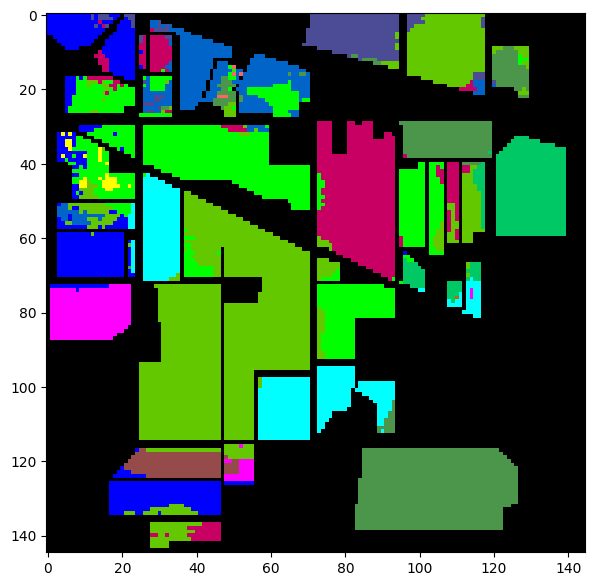

In [40]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

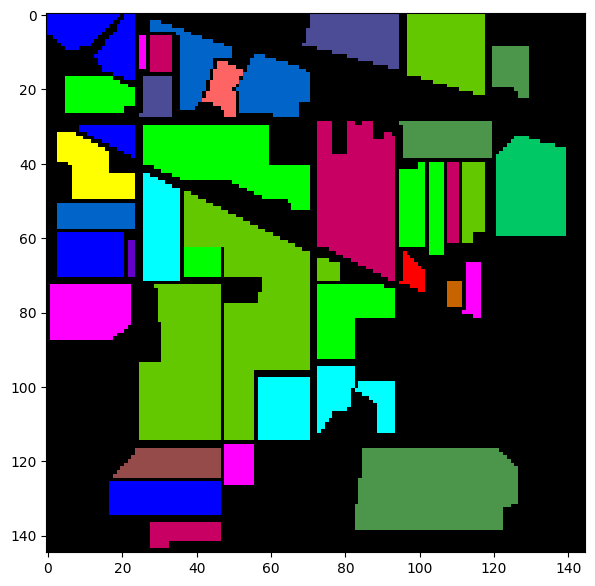

In [41]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))